# Multiple regression analysis in SQL with 2 independent variables
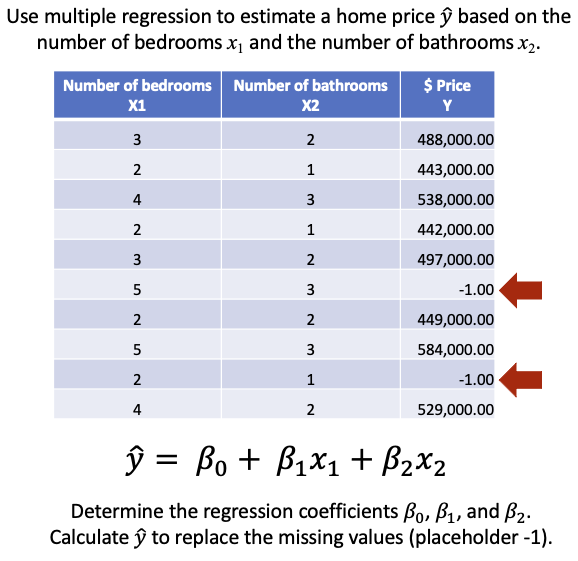

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from DATA225utils import make_connection, dataframe_query

In [ ]:
conn = make_connection(config_file = 'homes.ini')
cursor = conn.cursor()

In [ ]:
cursor.execute('DROP TABLE IF EXISTS homes')

sql = """
    CREATE TABLE homes
    (
        id        INT NOT NULL,
        bedrooms  INT NOT NULL,
        bathrooms INT NOT NULL,
        price     DOUBLE,
        PRIMARY KEY(id)
    )
    """

cursor.execute(sql)

## Home prices with missing prices
#### -1 is the placeholder for missing prices.

In [ ]:
bedrooms  = [      3,       2,       4,       2,       3,  5,       2,       5,  2,       4]
bathrooms = [      2,       1,       3,       1,       2,  3,       2,       3,  1,       2]
prices    = [488_000, 443_000, 538_000, 442_000, 497_000, -1, 449_000, 584_000, -1, 529_000]

values = list(zip(range(len(prices)), bedrooms, bathrooms, prices))
values

## Load the `homes` table

In [ ]:
sql = ( """
        INSERT INTO homes
        VALUES (%s, %s, %s, %s)
        """
      )

cursor.executemany(sql, values)
conn.commit()

## Function to display the `homes` table and return its rows

In [ ]:
def display_and_return(cursor):
    """
    Query the weights table, print its rows as a dataframe,
    and return the rows as a numpy array.
    """
    _, df = dataframe_query(conn, 'SELECT * FROM homes')
    
    pd.options.display.float_format = '${:,.2f}'.format
    display(df)
    
    return df.to_numpy()

## The dirty `homes` table
#### -1 is the placeholder for missing prices.

In [ ]:
rows = display_and_return(cursor)

## Function to execute multiple SQL statements

In [ ]:
def execute_multiple_SQL(cursor, sql, trace=False):
    """
    Use the cursor to execute multiple SQL statements.
    Print an execution trace if trace=True.
    """
    for crsr in cursor.execute(sql, multi=True):
        if crsr.with_rows:
            results = crsr.fetchall()
            if trace:
                print(crsr.statement)
                print('  ==> ', results)
        else:
            if trace:
                print(crsr.statement)
                if crsr.rowcount > 0:
                    print(f'  ==> {crsr.rowcount} row(s) affected.')

## SQL to clean the data

In [ ]:
sql = ( """
    START TRANSACTION;

    DROP VIEW IF EXISTS base;
    DROP VIEW IF EXISTS univariate_regression;
    DROP VIEW IF EXISTS residuals;
    DROP VIEW IF EXISTS multiple_regression_2;

    CREATE VIEW base AS
        SELECT
            id,

            bedrooms                          AS x1,
            bedrooms - AVG(bedrooms) OVER()   AS x1_centered,

            bathrooms                         AS x2,
            bathrooms - AVG(bathrooms) OVER() AS x2_centered,

            price                             AS y,
            price - AVG(price) OVER()         AS y_centered

        FROM homes
        WHERE price > 0;

    CREATE VIEW univariate_regression AS
        SELECT
            AVG(x2) - AVG(x1) * SUM(x2_centered * x1_centered)
                      / SUM(x1_centered * x1_centered)         AS x1_const,
            SUM(x2_centered * x1_centered)
                      / SUM(x1_centered * x1_centered)         AS beta1,
            AVG(x1) - AVG(x2) * SUM(x1_centered * x2_centered)
                      / SUM(x2_centered * x2_centered)         AS x2_const,
            SUM(x1_centered * x2_centered)
                      / SUM(x2_centered * x2_centered)         AS beta2
        FROM base;

    CREATE VIEW residuals AS 
        SELECT
            x1,
            x1 - (SELECT beta2    FROM univariate_regression) * x2
               - (SELECT x2_const FROM univariate_regression)      AS x1_resid,

            x2,
            x2 - (SELECT beta1    FROM univariate_regression) * x1
               - (SELECT x1_const FROM univariate_regression)      AS x2_resid,

            y,
            y_centered

        FROM base;

    CREATE VIEW multiple_regression_2 AS
        SELECT
            AVG(y) - AVG(x1) * SUM(y_centered * x1_resid)
                     / SUM(x1_resid * x1_resid)
                   - AVG(x2) * SUM(y_centered * x2_resid)
                     / SUM(x2_resid * x2_resid)           AS beta0,
            SUM(y_centered * x1_resid)
                / SUM(x1_resid * x1_resid)                AS beta1,
            SUM(y_centered * x2_resid)
                / SUM(x2_resid * x2_resid)                AS beta2

        FROM residuals;

    -- Replace missing home prices.

    SELECT *
    FROM multiple_regression_2
    INTO @beta_0, @beta_1, @beta_2;

    UPDATE homes
    SET price := @beta_0 + @beta_1*bedrooms + @beta_2*bathrooms
    WHERE price < 0;

    COMMIT;
    """
      )

## Clean the data

In [ ]:
execute_multiple_SQL(cursor, sql)

## The cleaned `homes` table

In [ ]:
rows = display_and_return(cursor)

## Obtain the regression coefficients

In [ ]:
cursor.execute('SELECT * FROM multiple_regression_2')
result = cursor.fetchone()

result

In [ ]:
df = DataFrame([result])
df.columns = ['β0', 'β1', 'β2']

pd.options.display.float_format = '{:,.2f}'.format
display(df)

In [ ]:
cursor.close()
conn.close()

## Regression coefficients using `numpy` matrix arithmetic

In [ ]:
X1 = rows[:, 1]  # bedrooms
X2 = rows[:, 2]  # bathrooms
Y  = rows[:, 3]  # price

In [ ]:
ones = np.array([1]*len(Y))
ones

In [ ]:
A = np.array([ones, X1, X2]).T
A

In [ ]:
ATA = A.T@A

b = Y
ATb = A.T@b

ATAinv = np.linalg.inv(ATA)
Xhat = ATAinv@ATb

Xhat

In [ ]:
β0 = Xhat[0]
β1 = Xhat[1]
β2 = Xhat[2]

df = DataFrame([[β0, β1, β2]])
df.columns = ['β0', 'β1', 'β2']

pd.options.display.float_format = '{:,.2f}'.format
display(df)

## Regression coefficients using `sklearn`

In [ ]:
from sklearn.linear_model import LinearRegression

X = np.array([X1, X2]).T

linear_regression = LinearRegression()
linear_regression.fit(X, Y)

β0 = linear_regression.intercept_
β1 = linear_regression.coef_[0]
β2 = linear_regression.coef_[1]

df = DataFrame([[β0, β1, β2]])
df.columns = ['β0', 'β1', 'β2']

pd.options.display.float_format = '{:,.2f}'.format
display(df)

## Error table

In [ ]:
Betas = np.array([β1, β2])
Yhat  = []

for x in X:
    Yhat.append(x@Betas + β0)

In [ ]:
Errors = Y - Yhat
table  = []

for i in range(len(Y)):
    pct = abs(100*Errors[i]/Y[i])
    row = np.concatenate([X[i], [Y[i], Yhat[i], Errors[i], pct]])
    
    table.append(row)

In [ ]:
df = DataFrame(table)
df.columns = ['bedrooms', 'bathrooms', 'price', 
              'est. price', 'error', '% error']

pd.options.display.float_format = '{:,.2f}'.format
display(df)

print(f'correlation coefficient = {np.corrcoef(Y, Yhat)[0, 1]:.2f}')

#### (c) 2023 by Ronald Mak